# This is a tutorial notebook for the `auto_oo` package

## Installation
First, create an anaconda or pip environment and install PyTorch, for example locally in a cpu-only installation:

```conda install pytorch cpuonly -c pytorch```

Optionally use GPU if your system supports it, but it is not recommended for small active spaces.

For now, it is only interfaced with PySCF to retrieve molecular structure info. This can be changed in the
future to our qc2nl datastructure. To install PySCF, run:

```pip install pyscf```

We need the updated version of Pennylane if you want to use np_fabrics ansatz, as it needed a bug-fix. Install it by cloning the pennylane repo and installing with `pip install -e .`.

After that, install the `auto_oo` package in the same way: clone the repo, then use `pip install -e .` in the cloned directory.


## Code structure

```
auto_oo
├── ansatz
│   ├── pqc.py - Here we generate parameterized quantum circuits. There is a method to extract states
│   │            and 1- and 2-Reduced Density Matrices (RDMs)
│   ├── kUpCCD.py -│ Different Ansätze that are modified from Pennylane to exclude single excitations,
│   └── uccd.py   -│ as we can deal with them in the classical orbital-optimization.
├── moldata_pyscf
│   └── moldata_pyscf.py - Interface to pyscf for extracting integrals and overlap matrices
│                          (and optionally do Hartree-Fock or CASSCF to compare results)
├── newton_raphson
│   └── newton_raphson.py - Performs single Newton-Raphson steps (optionally with regularization)
├── oo_energy
│   ├── integrals.py - Functions for computing active space integrals
│   └── oo_energy.py - Here the main code lives. This class is used to calculate auto-differentiable
│                      energies from 1- and 2-RDMs. It can compute analytical gradients and Hessians
│                      with respect to orbital rotations. It has a method to perform orbital optimization
│                      using the newton_raphson module. It is agnostic to the method used to retrieve RDMs.
└── oo_pqc
    ├── oo_pqc.py - A child of the OO_energy class. Here the Parameterized circuit and the oo_energy
    │               come together and with this the user is able to extract orbital and quantum
    │               circuit parameter gradients and (composite) Hessians. It has a method to perform
    │               full (circuit and orbital) optimization with Newton-Raphson steps.
    └── noisy_oo_pqc.py - Adaptation of the above class to include noisy gradients and Hessians used
                          in our sampling noise simulations.
```



In [1]:
import auto_oo
import pennylane as qml
import numpy as np
import torch
import openfermion
import cirq
import matplotlib.pyplot as plt

## Making a parameterized quantum circuit

First define the active space size and the pennylane device. For more information how pennylane handles quantum circuits, see https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html

In [2]:
ncas = 6
nelecas = 6
dev = qml.device('default.qubit', wires=2*ncas)

The `auto_oo.Parameterized_circuit` class has multiple native Ansatzes, like UCC(S)D and Number-preserving Fabrics. One can also input a custom `pennylane.QNode` that outputs a quantum state. Both the parameter vector and output state are `torch.Tensor` objects, that are compatible with automatic differentation in pytorch.

In [3]:
# auto_oo.Parameterized_circuit?

In [4]:
n_layers = 6

In [5]:
pqc = auto_oo.Parameterized_circuit(ncas, nelecas, dev, ansatz='np_fabric', n_layers=n_layers)

In [6]:
# Print the circuit for a random theta vector.
theta_test = torch.Tensor([np.random.random() for x in range(pqc.theta_shape)])
print(pqc.draw_circuit(theta_test))

 0: ──X────────╭G²(0.00)──────────────╭OrbitalRotation(0.00)─────────────────────────────────
 1: ──X────────├G²(0.00)──────────────├OrbitalRotation(0.00)─────────────────────────────────
 2: ──X────────├G²(0.00)──────────────├OrbitalRotation(0.00)─╭G²(0.48)─╭OrbitalRotation(0.59)
 3: ──X────────╰G²(0.00)──────────────╰OrbitalRotation(0.00)─├G²(0.48)─├OrbitalRotation(0.59)
 4: ──X────────╭G²(0.00)──────────────╭OrbitalRotation(0.00)─├G²(0.48)─├OrbitalRotation(0.59)
 5: ──X────────├G²(0.00)──────────────├OrbitalRotation(0.00)─╰G²(0.48)─╰OrbitalRotation(0.59)
 6: ───────────├G²(0.00)──────────────├OrbitalRotation(0.00)─╭G²(0.42)─╭OrbitalRotation(0.52)
 7: ───────────╰G²(0.00)──────────────╰OrbitalRotation(0.00)─├G²(0.42)─├OrbitalRotation(0.52)
 8: ─╭G²(0.00)─╭OrbitalRotation(0.00)────────────────────────├G²(0.42)─├OrbitalRotation(0.52)
 9: ─├G²(0.00)─├OrbitalRotation(0.00)────────────────────────╰G²(0.42)─╰OrbitalRotation(0.52)
10: ─├G²(0.00)─├OrbitalRotation(0.00)───────────────────────

To extract the state from the pqc class, call the attribute `qnode` that returns a `torch.Tensor`.

In [7]:
state = pqc.qnode(theta_test)
# We can visualize the state in dirac notation with the help of cirq. For this, convert it to a numpy array first:
print(cirq.dirac_notation(state.detach().numpy(), decimals=4))
# Note: for the np_fabric ansatz, we have a up-then-down spin-orbital ordering convention.

-0.0002|000011001111⟩ + 0.0003|000011011011⟩ + 0.0009|000011011110⟩ - 0.0003|000011100111⟩ - 0.0009|000011101101⟩ + 0.001|000011110011⟩ + 0.0033|000011110110⟩ - 0.0033|000011111001⟩ + 0.0015|000011111100⟩ + 0.0003|000100111110⟩ - 0.0002|000101101110⟩ - 0.0004|000101111010⟩ - 0.0001|000110011011⟩ + 0.0001|000110100111⟩ + 0.0003|000110101101⟩ - 0.0003|000110110011⟩ - 0.0007|000110110110⟩ + 0.0011|000110111001⟩ - 0.0003|000110111100⟩ - 0.0004|000111001011⟩ - 0.0027|000111001110⟩ - 0.006|000111011010⟩ + 0.0016|000111100011⟩ + 0.0103|000111100110⟩ - 0.0043|000111101001⟩ + 0.0052|000111101100⟩ - 0.0048|000111110010⟩ + 0.0062|000111111000⟩ - 0.0003|001000111101⟩ + 0.0001|001001011011⟩ + 0.0003|001001011110⟩ - 0.0001|001001100111⟩ + 0.0003|001001110011⟩ + 0.0011|001001110110⟩ - 0.0007|001001111001⟩ + 0.0003|001001111100⟩ - 0.0002|001010011101⟩ - 0.0004|001010110101⟩ + 0.0004|001011000111⟩ + 0.0027|001011001101⟩ - 0.0016|001011010011⟩ - 0.0043|001011010110⟩ + 0.0103|001011011001⟩ - 0.0052|00101

From this state, we can extract the 1- and 2-RDMS:

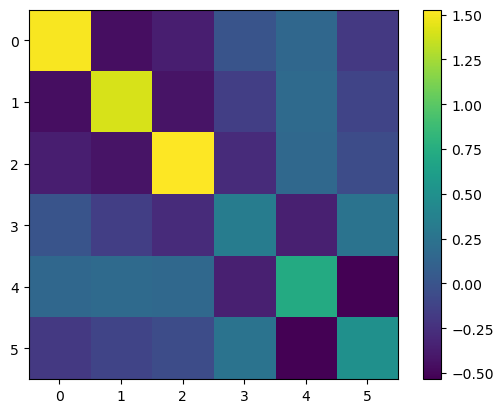

In [8]:
import warnings
warnings.simplefilter("ignore", UserWarning)

one_rdm, two_rdm = pqc.get_rdms_from_state(state)

plt.imshow(one_rdm)
plt.yticks(list(range(ncas)))
plt.xticks(list(range(ncas)))
plt.colorbar()
plt.show()

## Make a cost-function with a molecular Hamiltonian

### PySCF interface

Lets use formaldimine as an example. The `auto_oo` package is interfaced with PySCF to extract molecular properties using the `auto_oo.Moldata_pyscf` class. ![picture](formaldimine.png)

In [9]:
def get_formal_geo(alpha, phi):
    variables = [1.498047, 1.066797, 0.987109, 118.359375] + [alpha, phi]
    geom = """
                    N
                    C 1 {0}
                    H 2 {1}  1 {3}
                    H 2 {1}  1 {3} 3 180
                    H 1 {2}  2 {4} 3 {5}
                    """.format(*variables)
    return geom

In [10]:
alpha = 140
phi = 80
basis = 'sto-3g'
mol = auto_oo.Moldata_pyscf(get_formal_geo(alpha,phi), basis)

(13, 13)
(13, 13, 13, 13)


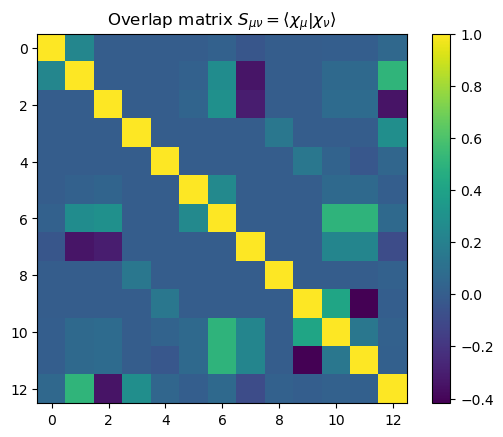

In [11]:
# This class stores the integrals and the overlap matrix for example:
print(mol.int1e_ao.shape)
print(mol.int2e_ao.shape)
plt.title(r'Overlap matrix $S_{\mu \nu} = \langle \chi_\mu | \chi_\nu \rangle$')
plt.imshow(mol.overlap)
plt.colorbar()
plt.show()

We can also run Hartree-Fock, CASCI or CASSCF with this class:

In [12]:
mol.run_rhf()
mol.run_casci(ncas, nelecas)
mol.run_casscf(ncas, nelecas)

In [13]:
print(f'Hartree-Fock energy: {mol.hf.e_tot:.6f}')
print(f'CASCI energy:        {mol.casci.e_tot:.6f}')
print(f'CASSCF energy:       {mol.casscf.e_tot:.6f}')

Hartree-Fock energy: -92.663722
CASCI energy:        -92.760464
CASSCF energy:       -92.800776


### Orbital Optimized energies and Hamiltonians

To extract Hamiltonian and energies in different MO basis, feed it into the `OO_energy` class. If you the user does not input any MO coefficients, it defaults to Hartree-Fock MOs.

In [14]:
oo_energy = auto_oo.OO_energy(mol, ncas, nelecas)

In [15]:
# Test if the MOs are indeed HF:
np.allclose(oo_energy.mo_coeff.detach().numpy(), mol.hf.mo_coeff)

True

We can compute the active space energy with the RDMs from the `pqc` class. In an active space, the total energy is given by:
$$
    E = E_{\rm nuc} + E_{\rm core} +
    \sum_{pq}\tilde{h}_{pq} \gamma_{pq} +
    \sum_{pqrs} g_{pqrs} \Gamma_{pqrs}
$$
where $E_{core}$ is the mean-field energy of the core (doubly-occupied) orbitals,
$\tilde{h}_{pq}$ is contains the active one-body terms plus the mean-field
interaction of core-active orbitals and $g_{pqrs}$ are the active integrals
in chemist ordering.

In [16]:
energy_random_theta = oo_energy.energy_from_mo_coeff(oo_energy.mo_coeff, one_rdm, two_rdm).item()

In [17]:
print(f'Energy with a random theta: {energy_random_theta:.6f}')

Energy with a random theta: -91.894860


Of course, the energy with a random theta is not great. While the `auto_oo` package is really only meant to give you primitives of energies and parameter derivatives, there is a method included to optimize the orbitals, that uses the  We can however optimize the orbitals for this specific state by calling the `orbital_optimization` method.

In [18]:
# For information on the Newton-Rapshon optimization procedure:
# auto_oo.NewtonStep?

In [19]:
energy_l = oo_energy.orbital_optimization(one_rdm, two_rdm)

iter = 000, energy = -92.325534104004
iter = 001, energy = -92.398997600943
iter = 002, energy = -92.404432018839
iter = 003, energy = -92.540704713267
iter = 004, energy = -92.592452929443
iter = 005, energy = -92.610446871326
iter = 006, energy = -92.632840918625
iter = 007, energy = -92.633280365014
iter = 008, energy = -92.638516411119
iter = 009, energy = -92.645137300344
iter = 010, energy = -92.645547936775
iter = 011, energy = -92.645556701338
iter = 012, energy = -92.645556711707
iter = 013, energy = -92.645556711707


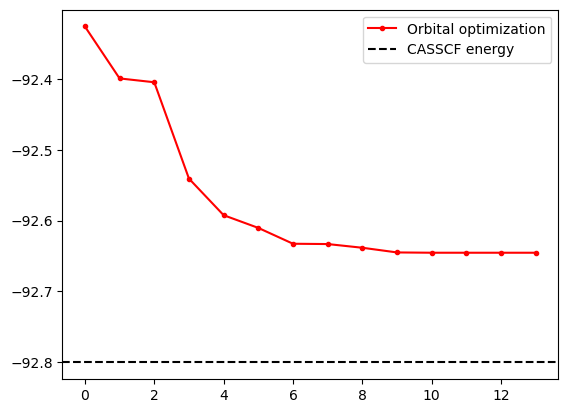

In [20]:
plt.plot(energy_l, '.-r', label='Orbital optimization')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF energy')
plt.legend()
plt.show()

## Optimizing a circuit 
While this gives us optimized orbitals for a random theta, a user usually often interested in optimizing he parameters as well. Lets do it for our optimized orbitals in the previous part. As this is not functionality that is inside `auto_oo`, we can import from PyTorch a gradient descent optimizer. 

First, extract the active space Hamiltonian

In [21]:
# We can extract the Hamiltonian as an openfermion FermionOperator for the optimized orbitals
c0, c1, c2 = oo_energy.get_active_integrals(torch.from_numpy(mol.hf.mo_coeff))
# c0, c1, c2 = oo_energy.get_active_integrals(oo_energy.mo_coeff)
fermionic_cas_hamiltonian = auto_oo.fermionic_cas_hamiltonian(c0, c1, c2)

In [22]:
fch_energies = openfermion.eigenspectrum(fermionic_cas_hamiltonian)
e_0 = fch_energies[0]
print(f'Based on HF orbitals, the CASCI ground state energy is: {e_0:.6f}')

For the optimized orbitals, the CASCI ground state energy is: -92.760464


In [23]:
qubit_cas_hamiltonian = openfermion.jordan_wigner(fermionic_cas_hamiltonian)

In [24]:
pennylane_cas_hamiltonian = qml.qchem.import_operator(qubit_cas_hamiltonian)

In [25]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def cost_function(theta):
    """ Outputs NP fabric ansatz state"""
    qml.GateFabric(theta,
                   wires=pqc.wires, init_state=pqc.hfstate, include_pi=False)
    return qml.expval(pennylane_cas_hamiltonian)

In [26]:
# theta = torch.zeros(len(pqc.redundant_idx) + pqc.theta_shape)
# theta[pqc.params_idx] = theta_test
# theta = theta.reshape(pqc.full_theta_shape)
theta = torch.zeros(pqc.full_theta_shape)
theta.requires_grad = True

energy_init = cost_function(theta).item()
# print("starting with random theta optimized orbitals gives us: energy_init)
print(f'Zero parameters give us an energy of:       {energy_init:.6f}')
print(f'Should be equal to the Hartree-Fock energy: {mol.hf.e_tot:.6f}')

Zero parameters give us an energy of:       -92.663722
Should be equal to the Hartree-Fock energy: -92.663722


In [27]:
# Define hyperparameters of the VQE optimization
max_iterations = 400
conv_tol = 1e-7
stepsize = 0.01
e_min = 1e99


# Save results in
opt_trajectory = [energy_init]
theta_trajectory = [theta.detach().clone()]

In [28]:
opt = torch.optim.Adam([theta],lr=stepsize)

In [29]:
torch.set_num_threads(16)

In [30]:
for n in range(max_iterations):

    opt.zero_grad()
    loss = cost_function(theta)
    loss.backward()
    opt.step()

    curr_energy = cost_function(theta).item()

    print('iter, e =', n, curr_energy)
    opt_trajectory.append(curr_energy)
    theta_trajectory.append(theta.detach().clone())

    if curr_energy < e_min:
        e_min = curr_energy
        n_min = n
        theta_min = theta.detach().clone()

    if n > 1:
        if (np.abs(opt_trajectory[-1] - opt_trajectory[-2])\
            < conv_tol):
            print("\nVQE converged")
            print(f'VQE energy: {opt_trajectory[-1]:.6f}')
            print(f'CASCI energy:  {mol.casci.e_tot:.6f}')
            break


iter, e = 0 -92.6663728419977
iter, e = 1 -92.66901887299909
iter, e = 2 -92.67171778494102
iter, e = 3 -92.6747224714249
iter, e = 4 -92.67791998487296
iter, e = 5 -92.68118010955448
iter, e = 6 -92.68442465137643
iter, e = 7 -92.68771043530981
iter, e = 8 -92.69104872898721
iter, e = 9 -92.6943220166133
iter, e = 10 -92.69743712195118
iter, e = 11 -92.70042623693341
iter, e = 12 -92.70341228510969
iter, e = 13 -92.70651613026966
iter, e = 14 -92.70978538292367
iter, e = 15 -92.71318239359013
iter, e = 16 -92.71662151325562
iter, e = 17 -92.72000193377798
iter, e = 18 -92.72322283124353
iter, e = 19 -92.72619577983492
iter, e = 20 -92.72886779722342
iter, e = 21 -92.73123930916019
iter, e = 22 -92.7333422744075
iter, e = 23 -92.73519547164825
iter, e = 24 -92.73678073787136
iter, e = 25 -92.73805191159317
iter, e = 26 -92.7389732894504
iter, e = 27 -92.73956176819831
iter, e = 28 -92.73988812632594
iter, e = 29 -92.74003583968185
iter, e = 30 -92.74007439912465
iter, e = 31 -92.740061

iter, e = 253 -92.75231457020794
iter, e = 254 -92.75233586602229
iter, e = 255 -92.75235782239696
iter, e = 256 -92.75238046800506
iter, e = 257 -92.7524038321654
iter, e = 258 -92.7524279447775
iter, e = 259 -92.75245283627125
iter, e = 260 -92.75247853754125
iter, e = 261 -92.75250507986803
iter, e = 262 -92.75253249484352
iter, e = 263 -92.75256081427739
iter, e = 264 -92.7525900701054
iter, e = 265 -92.7526202942746
iter, e = 266 -92.75265151863799
iter, e = 267 -92.75268377482048
iter, e = 268 -92.75271709408237
iter, e = 269 -92.75275150716686
iter, e = 270 -92.75278704413766
iter, e = 271 -92.75282373419275
iter, e = 272 -92.7528616054746
iter, e = 273 -92.75290068485712
iter, e = 274 -92.75294099772604
iter, e = 275 -92.75298256772568
iter, e = 276 -92.75302541652077
iter, e = 277 -92.7530695635084
iter, e = 278 -92.75311502553988
iter, e = 279 -92.7531618166187
iter, e = 280 -92.75320994757767
iter, e = 281 -92.75325942576394
iter, e = 282 -92.75331025469397
iter, e = 283 -92

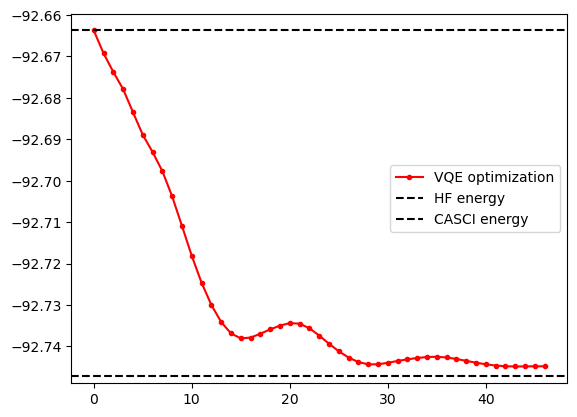

In [31]:
plt.plot(opt_trajectory, '.-r', label='VQE optimization')
plt.axhline(mol.hf.e_tot, ls='--', c='k', label='HF energy')
plt.axhline(mol.casci.e_tot, ls='--', c='k', label='CASCI energy')
plt.legend()
plt.show()

## Put the parameterized quantum circuit together with `OO_energy` with `OO_pqc_cost`

If you want a cost function dependent on both quantum circuit and orbital rotation parameters, use the `OO_energy` child class `OO_pqc_cost`. With this you can compute gradients to both parameters, and including composite Hessians.

In [32]:
oo_pqc = auto_oo.OO_pqc_cost(pqc, mol, ncas, nelecas, freeze_active=True)

In [33]:
oo_pqc.full_hessian(theta_test).shape

torch.Size([80, 80])

In [35]:
energy_l, theta_l, kappa_l, oao_mo_coeff_l, hess_eig_l = oo_pqc.full_optimization(theta_test)

iter = 000, energy = -92.128639114556
lowest eigval hessian = -0.7745783959081267
augmenting hessian...
Lowest eigenvalue of augmented hessian: 0.0774588395908257
new energy: -92.57754788351467
old energy: -92.12863911455553
wolfe: tensor(-5.6150e-05)
iter = 001, energy = -92.577547883515
lowest eigval hessian = -0.20931097454904085
augmenting hessian...
Lowest eigenvalue of augmented hessian: 0.020932097454911206
new energy: -92.60332383813237
old energy: -92.57754788351468
wolfe: tensor(-2.0228e-05)
iter = 002, energy = -92.603323838132
lowest eigval hessian = -0.21309053672070177
augmenting hessian...
Lowest eigenvalue of augmented hessian: 0.02131005367206345
test_energy: -92.54531985926701 ... old energy: -92.60332383813235
do backtracking line search...
t = 0.5
new energy: -92.71783400247989
old energy: -92.60332383813235
wolfe: tensor(-1.3729e-05)
iter = 003, energy = -92.717834002480
lowest eigval hessian = -0.05391891086617448
augmenting hessian...
Lowest eigenvalue of augment

In [36]:
print("\nOO-VQE converged")
print(f'OO-VQE energy: {energy_l[-1]:.6f}')
print(f'CASSCF energy: {mol.casscf.e_tot:.6f}')


OO-VQE converged
OO-VQE energy: -92.780814
CASSCF energy: -92.780814


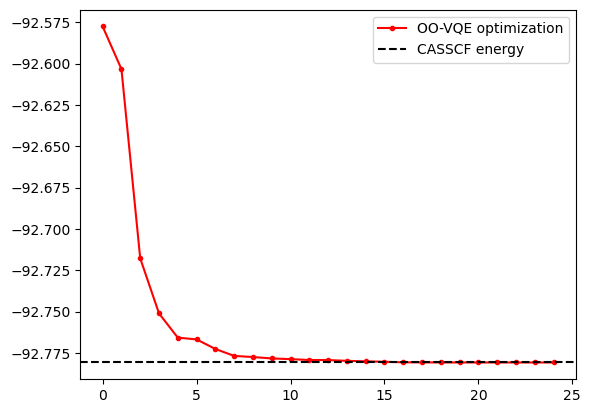

In [37]:
plt.plot(energy_l, '.-r', label='OO-VQE optimization')
# plt.axhline(mol.hf.e_tot, ls='--', c='k', label='HF energy')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF energy')
plt.legend()
plt.show()

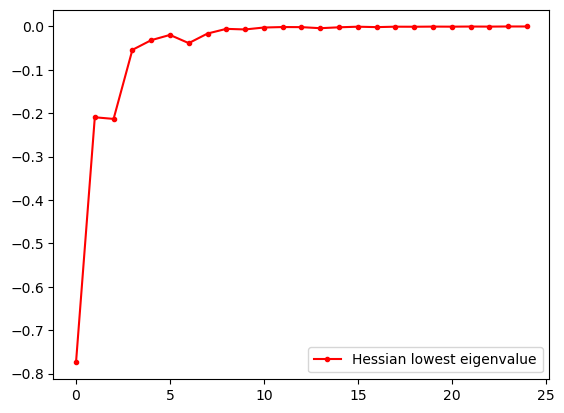

In [38]:
plt.plot(hess_eig_l, '.-r', label='Hessian lowest eigenvalue')
# plt.axhline(mol.hf.e_tot, ls='--', c='k', label='HF energy')
# plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF energy')
plt.legend()
plt.show()

In [31]:
for i in range(len(theta_test)):
    plt.plot([theta_l[j][i] for j in range(len(theta_l))], '.-', label=f'$\\theta {i}$')
# plt.axhline(mol.hf.e_tot, ls='--', c='k', label='HF energy')
# plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF energy')
# plt.legend()
plt.show()

NameError: name 'theta_l' is not defined